In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import utils as ut
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/house6311.csv')

In [3]:
df.head()

,Unnamed: 0,Unnamed: 1,STATE,DIST,INC,VOTE,TURNOUT,DELSOUTH
0,1896,1,1,1,NaN,0.282184,38482,0
1,1896,2,1,2,NaN,0.383052,58261,0
2,1896,3,1,3,NaN,0.334220,22934,0
3,1896,4,1,4,NaN,0.338997,46381,0
4,1896,5,2,1,NaN,0.312600,28119,0


In [4]:
df.columns = ['year', 'idx', 'state', 'dist', 'inc', 'vote_share', 'turnout', 'south']

In [5]:
df.head()
df.turnout.replace(df.turnout.min(), np.nan, inplace=True)

In [6]:
df['geom_id'] = df.state.apply(lambda x: str(x).rjust(2, '0')) + df.dist.apply(lambda x: str(x).rjust(2, '0'))

In [7]:
inc_dummies = pd.get_dummies(df.inc)
inc_dummies.columns = ['inc_r', 'no_inc', 'inc_d']
df = df.merge(inc_dummies,left_index=True, right_index=True)

In [8]:
nosouth = df.query('south == 0')

In [9]:
designs = ut.make_designs(nosouth)

/home/ljw/dissert/dev/seatsvotes/pyjudgeit/utils.py:12: UserWarning: computing redistricting from years vector
  warn('computing redistricting from years vector')


In [10]:
by_decade = {year:[elex for elex in designs if ((elex['year__this'].unique()-2)//10)*10 == year] 
             for year in 10*((df.year.unique()-2)//10)}

In [11]:
def estimate(df):
    weights = 1.0/df['turnout__this'].values
    cols = ['vote_share__prev'] + ['inc_r__this','no_inc__this','inc_d__this']
    cols += ['inc_r__prev','no_inc__prev','inc_d__prev']
    data = df[[col for col in cols if col in df.columns]]
    response = df[['vote_share__this']]
    try:
        model = sm.WLS(response, data, weights=weights, missing='drop').fit()
    except ValueError:
        return response, data, weights
    if 'vote_share__prev' not in df.columns:
        lambda_ = np.nan
        params = model.params
    else:
        lambda_ = model.params[0]
        params = model.params[1:]
    if 'inc_r__prev' not in df.columns:
        params = np.hstack([params, np.nan, np.nan, np.nan])
    params = np.hstack((lambda_, params))
    return model, params

In [12]:
cols = ['vote_share__prev'] + ['inc_r__this','no_inc__this','inc_d__this']
cols += ['inc_r__prev','no_inc__prev','inc_d__prev']

In [13]:
output = [estimate(dfi) for dfi in designs]

In [14]:
lambda_ = [model[1][0] for model in output[1:]]

In [15]:
models = [model[0] for model in output[1:]]

In [16]:
decades = np.sort(df.year.unique())
decades = ((decades-2) // 10)*10

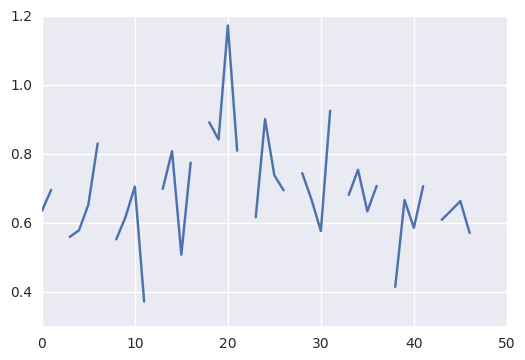

In [17]:
plt.plot(lambda_)

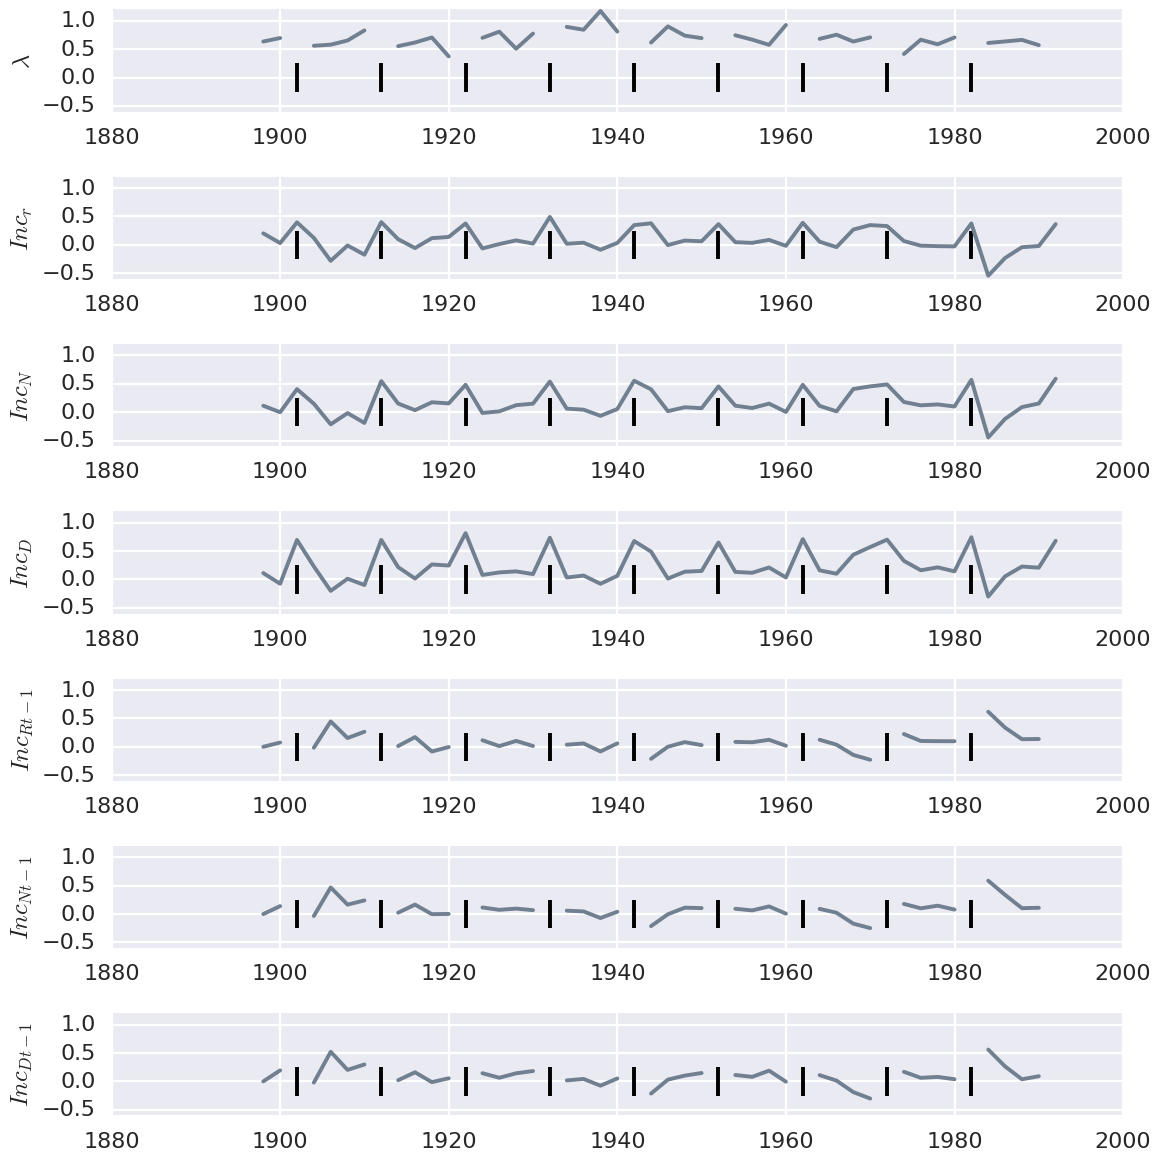

In [39]:
cols = ['$\lambda$', '$Inc_r$', '$Inc_N$', '$Inc_D$', '$Inc_{Rt-1}$','$Inc_{Nt-1}$','$Inc_{Dt-1}$']
sns.set_context('poster')
years = np.sort(df.year.unique())
f,ax = plt.subplots(len(cols), 1, figsize=(12,12), sharey=True)
for i, param in enumerate(np.asarray([out[1].tolist() for out in output[1:]]).T):
    ax[i].plot(years[1:], param, 'slategrey')
    ax[i].set_ylabel(cols[i])
    ax[i].vlines([1900+10*i+2 for i in range(9)], -.25,.25)
f.tight_layout()
plt.show()

In [40]:
models[-1].params

inc_r__this     0.364593
no_inc__this    0.588710
inc_d__this     0.681762
dtype: float64

In [41]:
import patsy as pt